In [70]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pathlib

import tensorflow as tf
from keras import layers
from keras.models import Sequential

In [71]:
data_dir = "/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/dataset_pca_50/train"
data_test_dir = "/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/dataset_pca_50/test"

In [72]:
data_dir = pathlib.Path(data_dir)
data_test_dir = pathlib.Path(data_test_dir)

In [73]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

1836


### Visualizing one image per class

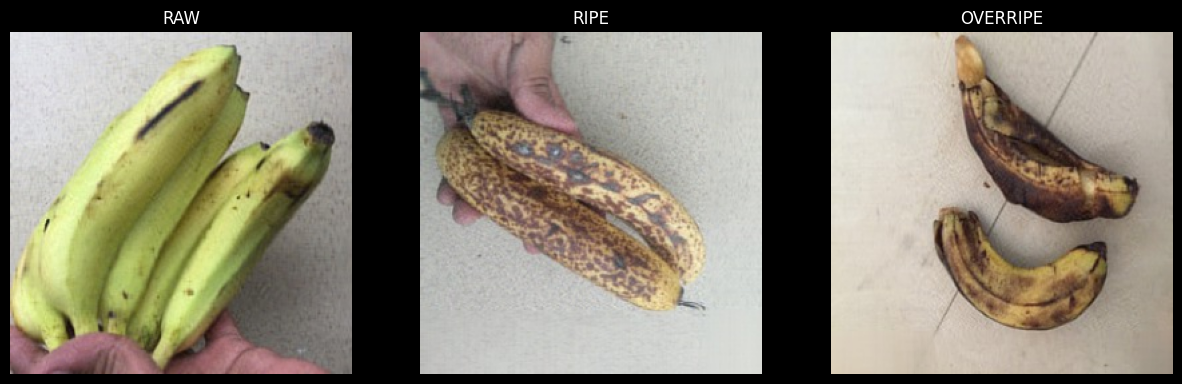

In [74]:
raw = str(list(data_dir.glob("raw/*.jpg"))[10])
ripe = str(list(data_dir.glob("ripe/*.jpg"))[10])
overripe = str(list(data_dir.glob("overripe/*.jpg"))[10])

ax, sub = plt.subplots(1, 3, figsize=(15, 15))
sub[0].set_title("RAW")
sub[0].axis("off")
sub[0].imshow(cv.cvtColor(cv.imread(raw), cv.COLOR_BGR2RGB))

sub[1].set_title("RIPE")
sub[1].axis("off")
sub[1].imshow(cv.cvtColor(cv.imread(ripe), cv.COLOR_BGR2RGB))

sub[2].set_title("OVERRIPE")
sub[2].axis("off")
sub[2].imshow(cv.cvtColor(cv.imread(overripe), cv.COLOR_BGR2RGB))

## Dividing the dataset

In [75]:
batch_size = 32
img_height = 256
img_width = 256

In [76]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    # image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1836 files belonging to 3 classes.
Using 1469 files for training.


In [77]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    # image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1836 files belonging to 3 classes.
Using 367 files for validation.


In [78]:
class_names = train_ds.class_names
print(class_names)

['overripe', 'raw', 'ripe']


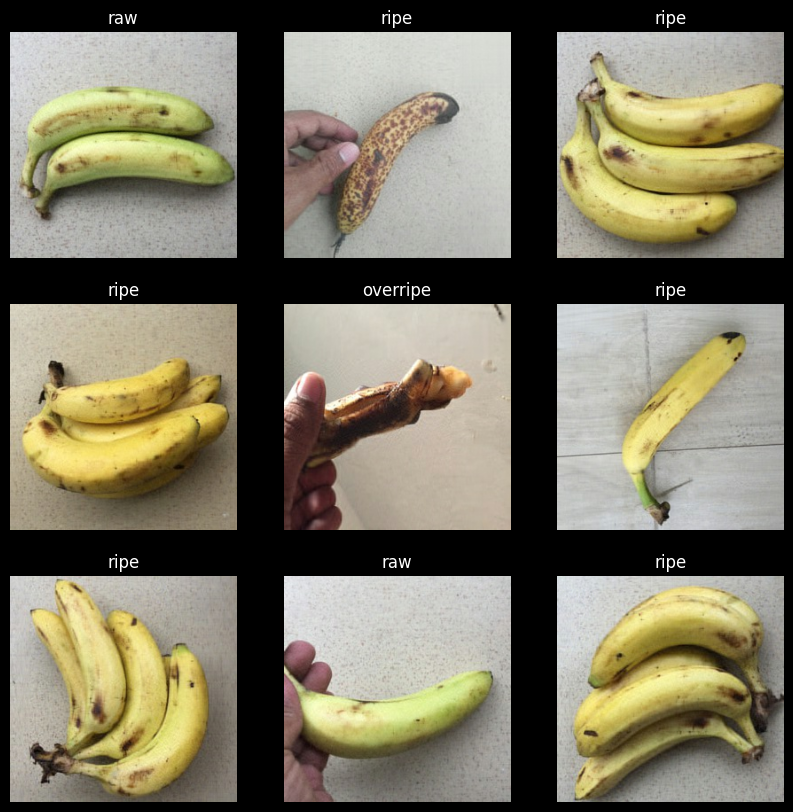

In [79]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data augmentation

In [80]:
num_classes = len(class_names)

In [81]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
# ])

In [82]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         # ax = plt.subplot(3, 3, i + 1)
#         # plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

### Model

In [83]:
model = Sequential(
    [
        # data_augmentation,
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

In [84]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)       

In [86]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


25/46 [===============>..............] - ETA: 15s - loss: 1.3380 - accuracy: 0.6037

## Visualize Training Results

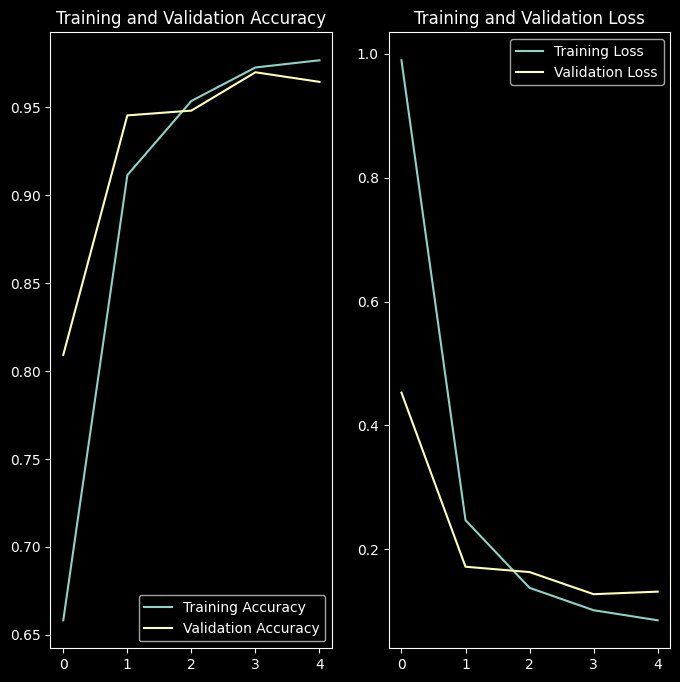

In [30]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# pre = tf.keras.metrics.Precision()
# re = tf.keras.metrics.Recall()
# acc = tf.keras.metrics.Accuracy()

# test = keras.utils.image_dataset_from_directory(data_test_dir)

# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
# print(f"Accuracy: {acc.result().numpy()}")

## Test

### Defining helper function

In [36]:
def predict_image_from_path(img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    return res, percentage

### One Image

This image most likely belongs to ripe with a 99.97 percent confidence.


(-0.5, 255.5, 255.5, -0.5)

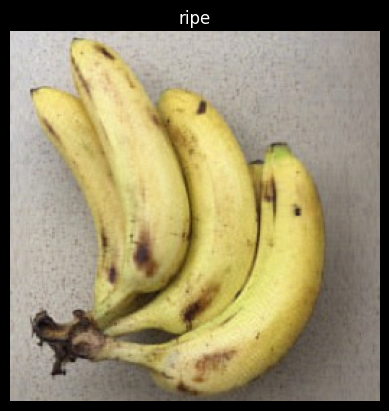

In [44]:
img_ripe = str(list(data_test_dir.glob("ripe/*.jpg"))[10])

res = predict_image_from_path(img_ripe)

plt.imshow(cv.cvtColor(cv.imread(img_ripe), cv.COLOR_BGR2RGB))
plt.title(res[0])
plt.axis("off")

### One directory of images

#### RAW

In [49]:
expected_class = "raw"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to raw with a 98.03 percent confidence.
This image most likely belongs to raw with a 99.90 percent confidence.
This image most likely belongs to raw with a 99.89 percent confidence.
This image most likely belongs to raw with a 99.60 percent confidence.
This image most likely belongs to raw with a 97.78 percent confidence.
This image most likely belongs to raw with a 97.89 percent confidence.
This image most likely belongs to raw with a 99.48 percent confidence.
This image most likely belongs to raw with a 91.10 percent confidence.
This image most likely belongs to raw with a 97.39 percent confidence.
This image most likely belongs to raw with a 99.88 percent confidence.
This image most likely belongs to raw with a 99.61 percent confidence.
This image most likely belongs to raw with a 99.61 percent confidence.
This image most likely belongs to raw with a 98.82 percent confidence.
This image most likely belongs to raw with a 99.58 percent confidence.
This i

#### RIPE

In [50]:
expected_class = "ripe"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to ripe with a 99.82 percent confidence.
This image most likely belongs to ripe with a 99.76 percent confidence.
This image most likely belongs to ripe with a 99.01 percent confidence.
This image most likely belongs to ripe with a 94.38 percent confidence.
This image most likely belongs to ripe with a 99.96 percent confidence.
This image most likely belongs to ripe with a 99.71 percent confidence.
This image most likely belongs to ripe with a 98.19 percent confidence.
This image most likely belongs to ripe with a 98.85 percent confidence.
This image most likely belongs to ripe with a 99.86 percent confidence.
This image most likely belongs to ripe with a 92.41 percent confidence.
This image most likely belongs to ripe with a 99.97 percent confidence.
This image most likely belongs to ripe with a 99.77 percent confidence.
This image most likely belongs to ripe with a 99.87 percent confidence.
This image most likely belongs to ripe with a 99.91 percent conf

#### OVERRIPE

In [51]:
expected_class = "overripe"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to overripe with a 91.33 percent confidence.
This image most likely belongs to overripe with a 86.96 percent confidence.
This image most likely belongs to overripe with a 90.13 percent confidence.
This image most likely belongs to overripe with a 93.67 percent confidence.
This image most likely belongs to overripe with a 91.36 percent confidence.
This image most likely belongs to overripe with a 93.11 percent confidence.
This image most likely belongs to overripe with a 95.78 percent confidence.
This image most likely belongs to overripe with a 84.38 percent confidence.
This image most likely belongs to overripe with a 77.82 percent confidence.
This image most likely belongs to overripe with a 95.63 percent confidence.
This image most likely belongs to overripe with a 76.77 percent confidence.
This image most likely belongs to overripe with a 82.01 percent confidence.
This image most likely belongs to overripe with a 92.36 percent confidence.
This image m

### Three directories of images

In [57]:
raw_right = 0
ripe_right = 0
overripe_right = 0

for img_class in os.listdir(data_test_dir):
    for img in os.listdir(os.path.join(data_test_dir, img_class)):
        img_path = os.path.join(data_test_dir, img_class, img)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "raw" and res == "raw":
            raw_right += 1
        elif img_class == "ripe" and res == "ripe":
            overripe_right += 1
        elif img_class == "overripe" and res == "overripe":
            ripe_right += 1

    print()

raw_size = len(os.listdir(os.path.join(data_test_dir, "raw")))
overripe_size = len(os.listdir(os.path.join(data_test_dir, "ripe")))
ripe_size = len(os.listdir(os.path.join(data_test_dir, "overripe")))
total_size = raw_size + overripe_size + ripe_size
total_right = raw_right + overripe_right + ripe_right

print(
    f"Result raw: got { raw_right }/{ raw_size } right, which means { round(raw_right * 100 / raw_size, 2) }%"
)
print(
    f"Result overripe: got { overripe_right }/{ overripe_size } right, which means { round(overripe_right * 100 / overripe_size, 2) }%"
)
print(
    f"Result ripe: got { ripe_right }/{ ripe_size } right, which means { round(ripe_right * 100 / ripe_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to overripe with a 91.33 percent confidence.
This image most likely belongs to overripe with a 86.96 percent confidence.
This image most likely belongs to overripe with a 90.13 percent confidence.
This image most likely belongs to overripe with a 93.67 percent confidence.
This image most likely belongs to overripe with a 91.36 percent confidence.
This image most likely belongs to overripe with a 93.11 percent confidence.
This image most likely belongs to overripe with a 95.78 percent confidence.
This image most likely belongs to overripe with a 84.38 percent confidence.
This image most likely belongs to overripe with a 77.82 percent confidence.
This image most likely belongs to overripe with a 95.63 percent confidence.
This image most likely belongs to overripe with a 76.77 percent confidence.
This image most likely belongs to overripe with a 82.01 percent confidence.
This image most likely belongs to overripe with a 92.36 percent confidence.
This image m

### Testing with images taken by me

In [68]:
raw_right = 0
ripe_right = 0
overripe_right = 0

imgs_taken_by_me_path = "/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/taken_by_me/dataset_pca/"

for img_class in os.listdir(imgs_taken_by_me_path):
    for img in os.listdir(os.path.join(imgs_taken_by_me_path, img_class)):
        img_path = os.path.join(imgs_taken_by_me_path, img_class, img)
        # print(img_path)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "raw" and res == "raw":
            raw_right += 1
        elif img_class == "ripe" and res == "ripe":
            overripe_right += 1
        elif img_class == "overripe" and res == "overripe":
            ripe_right += 1
    print()

raw_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "raw")))
overripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "ripe")))
ripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "overripe")))
total_size = raw_size + overripe_size + ripe_size
total_right = raw_right + overripe_right + ripe_right

print(
    f"Result raw: got { raw_right }/{ raw_size } right, which means { round(raw_right * 100 / raw_size, 2) }%"
)
print(
    f"Result overripe: got { overripe_right }/{ overripe_size } right, which means { round(overripe_right * 100 / overripe_size, 2) }%"
)
print(
    f"Result ripe: got { ripe_right }/{ ripe_size } right, which means { round(ripe_right * 100 / ripe_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to overripe with a 99.70 percent confidence.
This image most likely belongs to ripe with a 99.76 percent confidence.
This image most likely belongs to overripe with a 68.22 percent confidence.
This image most likely belongs to ripe with a 99.75 percent confidence.
This image most likely belongs to overripe with a 90.43 percent confidence.

This image most likely belongs to raw with a 72.64 percent confidence.
This image most likely belongs to raw with a 60.23 percent confidence.
This image most likely belongs to ripe with a 76.72 percent confidence.
This image most likely belongs to ripe with a 64.29 percent confidence.
This image most likely belongs to ripe with a 81.26 percent confidence.

This image most likely belongs to ripe with a 83.28 percent confidence.
This image most likely belongs to ripe with a 99.99 percent confidence.
This image most likely belongs to ripe with a 99.95 percent confidence.
This image most likely belongs to overripe with a 91

## Save

In [52]:
model.save('models/banana_stages_classifier.h5')


In [53]:
loaded_model = tf.keras.models.load_model('models/banana_stages_classifier.h5')

In [54]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       